# Machine learning modeling

In [1]:
#the used packages
from warnings import filterwarnings
filterwarnings("ignore")

# data visualisation and manipulation
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation.
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import  LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Evaluation.
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#classifiaction models.
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Helper Function

In [2]:
def change_into_Datetime(df,col):
    '''
    This function takes a data frame and a column and change the type of column to timestamp. 
    '''
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d %H:%M:%S")
    return (df[col].dtypes)

In [3]:
def set_sort_datetime_index(df):
    '''
    This function take a data frame, sort it by datetime column, set the datetime column as index.
    '''
    df.set_index('datetime', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    return df.head(5)

In [4]:
def rename_df_col(df,suffix):
    '''
    this function change the column's name in a data frame by adding a suffix.
    '''
    old_names=list(df.columns)
    new_names= [i + suffix for i in old_names]
    name_dic={old_names[i]: new_names[i] for i in range(len(old_names))}
    return df.rename(columns = name_dic, inplace = True)
    

In [5]:
def classification_report_heatmap(y_test,y_pred, model_name=""):
    '''
    this function for display classification report heat map 
    '''
    color=["#845EC2", "#D65DB1", "#FF6F91", "#FF9671", "#FFC75F", "#008F7A", "#F9F871"]
    y_lable=['No_failure', 'comp1', 'comp2', 'comp3', 'comp4','micro avg','macro avg','weighted avg','samples avg']
    plt.figure(figsize=(9, 4), facecolor='white')
    plt.title(f"{model_name} Classification Report Heat Map")
    cr=classification_report(y_test,y_pred, output_dict=True)
    sns.heatmap(pd.DataFrame(cr).iloc[:-1].T, annot=True, cmap=color, yticklabels=y_lable);
    return cr

In [6]:
def confusion_matrix_display(y_pred, y_test,model_name):
    '''
    this function for display the confusion matrix.

    '''
    labels=['No_failure', 'comp1', 'comp2', 'comp3', 'comp4']
    fig, ax = plt.subplots(figsize=(6, 6), facecolor='white')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax);
    ax.set_title(f"{model_name} Classification Confusion Matrix")

In [7]:
def comp_failure_scores(models, crs, metric):
    '''
    this function compare one metric of two different models. It takes the classification report of the models and return the metric of these models as a data frame.

    ''' 
    ftsdf = pd.DataFrame({
        "Model": models,
        "No Failure": [pd.DataFrame(cr)["0"][metric] for cr in crs],
        "comp 1": [pd.DataFrame(cr)["1"][metric] for cr in crs],
        "comp 2": [pd.DataFrame(cr)["2"][metric] for cr in crs],
        "comp 3": [pd.DataFrame(cr)["3"][metric] for cr in crs],
        "comp 4": [pd.DataFrame(cr)["4"][metric] for cr in crs]
    })
    
    return ftsdf

# Data loading

In [8]:
#loading the data
df_telemetry=pd.read_csv('data/PdM_telemetry.csv')
df_errors=pd.read_csv('data/PdM_errors.csv')
df_maint=pd.read_csv('data/PdM_maint.csv')
df_failures=pd.read_csv('data/PdM_failures.csv')
df_machines=pd.read_csv('data/PdM_machines.csv')

In [9]:
dataframes=[df_telemetry,df_errors,df_maint,df_failures]
for df in dataframes:
    change_into_Datetime(df,'datetime')

# Feature  selecting

The feature data will have a recored every 4 hours and it will containe:
- Statistical summary for each of the volt, rotate, pressure and vibration of the last four hours. That is the mininum, maximun , median and the main of the last four hours.
- Similar statistical summary but for the last 24 hours.
- Age of the machine.
- Model of the machine. 
- Total number of each errorID in the last 24 hours.
- The age of the componant i.e. hours since the last change.

In [10]:
#creat lag features for volt, rotate, pressure, vibration for last 4 hours and 24 hours.
feature_window_1= '4h' # for resample
feature_window_2= 24

In [11]:
# create the summary of the last 4 hours.
set_sort_datetime_index(df_telemetry)
grouped = df_telemetry.groupby('machineID')


resampled_min = grouped.resample(feature_window_1, closed='left', label='right').min().drop(columns='machineID')
resampled_max = grouped.resample(feature_window_1, closed='left', label='right').max().drop(columns='machineID')
resampled_mean = grouped.resample(feature_window_1, closed='left', label='right').mean().drop(columns='machineID')
resampled_median = grouped.resample(feature_window_1, closed='left', label='right').median().drop(columns='machineID')

In [12]:
rename_df_col(resampled_min,'_min_4h')
rename_df_col(resampled_max,'_max_4h')
rename_df_col(resampled_mean,'_mean_4h')
rename_df_col(resampled_median,'_median_4h')

In [13]:
df_features= resampled_min.join(resampled_max)
df_features= df_features.join(resampled_mean)
df_features= df_features.join(resampled_median)

In [14]:
df_features.reset_index(inplace=True)

In [15]:
df_features=df_features.dropna()

In [16]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219100 entries, 0 to 219099
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   machineID            219100 non-null  int64         
 1   datetime             219100 non-null  datetime64[ns]
 2   volt_min_4h          219100 non-null  float64       
 3   rotate_min_4h        219100 non-null  float64       
 4   pressure_min_4h      219100 non-null  float64       
 5   vibration_min_4h     219100 non-null  float64       
 6   volt_max_4h          219100 non-null  float64       
 7   rotate_max_4h        219100 non-null  float64       
 8   pressure_max_4h      219100 non-null  float64       
 9   vibration_max_4h     219100 non-null  float64       
 10  volt_mean_4h         219100 non-null  float64       
 11  rotate_mean_4h       219100 non-null  float64       
 12  pressure_mean_4h     219100 non-null  float64       
 13  vibration_mean

In [17]:
#creat summary of the last 24 hours.
rolling_min_24h = grouped.rolling(window=feature_window_2).min()
rolling_max_24h = grouped.rolling(window=feature_window_2).max()
rolling_mean_24h = grouped.rolling(window=feature_window_2).mean()
rolling_median_24h = grouped.rolling(window=feature_window_2).median()

In [18]:
rename_df_col(rolling_min_24h,'_min_24h')
rename_df_col(rolling_max_24h,'_max_24h')
rename_df_col(rolling_mean_24h,'_mean_24h')
rename_df_col(rolling_median_24h,'_median_24h')

In [19]:
df_features_24= rolling_max_24h.join(rolling_min_24h)
df_features_24= df_features_24.join(rolling_median_24h)
df_features_24= df_features_24.join(rolling_mean_24h)

In [20]:
df_features_24.reset_index(inplace=True)

In [21]:
df_features=pd.merge(df_features,df_features_24,how='left')

In [22]:
df_features=df_features.dropna()

In [23]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218400 entries, 6 to 219098
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   machineID             218400 non-null  int64         
 1   datetime              218400 non-null  datetime64[ns]
 2   volt_min_4h           218400 non-null  float64       
 3   rotate_min_4h         218400 non-null  float64       
 4   pressure_min_4h       218400 non-null  float64       
 5   vibration_min_4h      218400 non-null  float64       
 6   volt_max_4h           218400 non-null  float64       
 7   rotate_max_4h         218400 non-null  float64       
 8   pressure_max_4h       218400 non-null  float64       
 9   vibration_max_4h      218400 non-null  float64       
 10  volt_mean_4h          218400 non-null  float64       
 11  rotate_mean_4h        218400 non-null  float64       
 12  pressure_mean_4h      218400 non-null  float64       
 13 

In [24]:
#add age and model of the machines .
df_features=pd.merge(df_features,df_machines,how='left')

In [25]:
df_features.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 218400 entries, 0 to 218399
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   machineID             218400 non-null  int64         
 1   datetime              218400 non-null  datetime64[ns]
 2   volt_min_4h           218400 non-null  float64       
 3   rotate_min_4h         218400 non-null  float64       
 4   pressure_min_4h       218400 non-null  float64       
 5   vibration_min_4h      218400 non-null  float64       
 6   volt_max_4h           218400 non-null  float64       
 7   rotate_max_4h         218400 non-null  float64       
 8   pressure_max_4h       218400 non-null  float64       
 9   vibration_max_4h      218400 non-null  float64       
 10  volt_mean_4h          218400 non-null  float64       
 11  rotate_mean_4h        218400 non-null  float64       
 12  pressure_mean_4h      218400 non-null  float64       
 13 

In [26]:
df_features = pd.get_dummies(df_features)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218400 entries, 0 to 218399
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   machineID             218400 non-null  int64         
 1   datetime              218400 non-null  datetime64[ns]
 2   volt_min_4h           218400 non-null  float64       
 3   rotate_min_4h         218400 non-null  float64       
 4   pressure_min_4h       218400 non-null  float64       
 5   vibration_min_4h      218400 non-null  float64       
 6   volt_max_4h           218400 non-null  float64       
 7   rotate_max_4h         218400 non-null  float64       
 8   pressure_max_4h       218400 non-null  float64       
 9   vibration_max_4h      218400 non-null  float64       
 10  volt_mean_4h          218400 non-null  float64       
 11  rotate_mean_4h        218400 non-null  float64       
 12  pressure_mean_4h      218400 non-null  float64       
 13 

In [27]:
# add the errors.
error_feature = pd.get_dummies(df_errors.set_index('datetime'))
error_feature.columns = ['machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
error_feature = error_feature.groupby(['machineID', 'datetime']).sum().reset_index()
error_feature

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0
...,...,...,...,...,...,...,...
3611,100,2015-11-12 01:00:00,1,0,0,0,0
3612,100,2015-11-21 08:00:00,0,1,0,0,0
3613,100,2015-12-04 02:00:00,1,0,0,0,0
3614,100,2015-12-08 06:00:00,0,1,1,0,0


In [28]:
#creat lag features for number of error in  last 24 hours.
df_telemetry.reset_index(inplace=True)
change_into_Datetime(error_feature,'datetime')
df=pd.merge(df_telemetry[['datetime', 'machineID']],error_feature, on=['machineID', 'datetime'], how='left').fillna(0.0)
df.set_index('datetime', inplace=True)
error_grouped=df.groupby(['machineID'])
rolling_error_24h = error_grouped.rolling(window=feature_window_2,closed='left').sum()
rename_df_col(rolling_error_24h,'total_24h')
rolling_error_24h.reset_index(inplace=True)
change_into_Datetime(rolling_error_24h,'datetime')

df_features=pd.merge(df_features,rolling_error_24h,how='left')
df_features.dropna()
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218400 entries, 0 to 218399
Data columns (total 44 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   machineID             218400 non-null  int64         
 1   datetime              218400 non-null  datetime64[ns]
 2   volt_min_4h           218400 non-null  float64       
 3   rotate_min_4h         218400 non-null  float64       
 4   pressure_min_4h       218400 non-null  float64       
 5   vibration_min_4h      218400 non-null  float64       
 6   volt_max_4h           218400 non-null  float64       
 7   rotate_max_4h         218400 non-null  float64       
 8   pressure_max_4h       218400 non-null  float64       
 9   vibration_max_4h      218400 non-null  float64       
 10  volt_mean_4h          218400 non-null  float64       
 11  rotate_mean_4h        218400 non-null  float64       
 12  pressure_mean_4h      218400 non-null  float64       
 13 

In [29]:
# creat a data frame for componant replacment.
df_failures.rename(columns={'failure': 'comp'}, inplace=True)
df_maint_fail = pd.merge(df_maint, df_failures, how='outer')
comp_replaced=df_maint_fail[['datetime','machineID','comp']].copy()
comp_replaced = pd.get_dummies(df_maint_fail.set_index('datetime'))
comp_replaced.columns = ['machineID', 'comp1', 'comp2', 'comp3', 'comp4']
comp_replaced = comp_replaced.groupby(['machineID', 'datetime']).sum().reset_index()
change_into_Datetime(comp_replaced,'datetime')
comp_replaced=pd.merge(comp_replaced,df_features[['datetime','machineID']],how='outer').fillna(0)
comp_replaced.sort_values(['machineID', 'datetime'],axis = 0, ascending = True, inplace = True)
comp_replaced

,machineID,datetime,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,0.0,1.0,0.0,0.0
1,1,2014-07-16 06:00:00,0.0,0.0,0.0,1.0
2,1,2014-07-31 06:00:00,0.0,0.0,1.0,0.0
3,1,2014-12-13 06:00:00,1.0,0.0,0.0,0.0
2545,1,2015-01-02 08:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
220940,100,2015-12-31 12:00:00,0.0,0.0,0.0,0.0
220941,100,2015-12-31 16:00:00,0.0,0.0,0.0,0.0
220942,100,2015-12-31 20:00:00,0.0,0.0,0.0,0.0
220943,100,2016-01-01 00:00:00,0.0,0.0,0.0,0.0


In [30]:
#calculate the age of the componants in hours.
componant_age=comp_replaced.copy()
frames = []
componant= ['comp1','comp2','comp3','comp4']
for machineId in range(1,101):
    df_temp=componant_age.loc[componant_age['machineID']==machineId]
    for comp in componant:
        df_temp.loc[df_temp[comp] > 0, comp] = np.nan
        df_temp[comp] = df_temp[comp].fillna(componant_age['datetime'])
        df_temp.loc[df_temp[comp] == 0, comp] = np.nan
        df_temp[comp]=df_temp[comp].fillna(method='ffill')
    frames.append(df_temp)
componant_age=pd.concat(frames)
componant_age=componant_age.dropna()
for comp in componant:
    componant_age[comp+'age']=(componant_age['datetime'] - componant_age[comp]) / np.timedelta64(1, 'h')
componant_age=componant_age.drop(columns=componant)
componant_age.reset_index(drop=True,inplace=True)
componant_age

,machineID,datetime,comp1age,comp2age,comp3age,comp4age
0,1,2014-12-13 06:00:00,0.0,4680.0,3240.0,3600.0
1,1,2015-01-02 08:00:00,482.0,5162.0,3722.0,4082.0
2,1,2015-01-02 12:00:00,486.0,5166.0,3726.0,4086.0
3,1,2015-01-02 16:00:00,490.0,5170.0,3730.0,4090.0
4,1,2015-01-02 20:00:00,494.0,5174.0,3734.0,4094.0
...,...,...,...,...,...,...
220675,100,2015-12-31 12:00:00,1974.0,174.0,1974.0,1254.0
220676,100,2015-12-31 16:00:00,1978.0,178.0,1978.0,1258.0
220677,100,2015-12-31 20:00:00,1982.0,182.0,1982.0,1262.0
220678,100,2016-01-01 00:00:00,1986.0,186.0,1986.0,1266.0


In [31]:
df_features=pd.merge(df_features,componant_age,how='left')
df_features.dropna(inplace= True)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218400 entries, 0 to 218399
Data columns (total 48 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   machineID             218400 non-null  int64         
 1   datetime              218400 non-null  datetime64[ns]
 2   volt_min_4h           218400 non-null  float64       
 3   rotate_min_4h         218400 non-null  float64       
 4   pressure_min_4h       218400 non-null  float64       
 5   vibration_min_4h      218400 non-null  float64       
 6   volt_max_4h           218400 non-null  float64       
 7   rotate_max_4h         218400 non-null  float64       
 8   pressure_max_4h       218400 non-null  float64       
 9   vibration_max_4h      218400 non-null  float64       
 10  volt_mean_4h          218400 non-null  float64       
 11  rotate_mean_4h        218400 non-null  float64       
 12  pressure_mean_4h      218400 non-null  float64       
 13 

# Data labeling

##  Case 1

In this case the data will labeled failed only when a component is changed because the machine is failed. Therefore only the data from the file  PdM_failures.csv will be uesed for labeling. And the componant will be considered failed for 24 hours before changing.

In [32]:
df_failures=df_failures.merge(df_telemetry[['datetime','machineID']],how='outer')
df_failures.sort_values(['machineID','datetime'],axis = 0, ascending = True, inplace = True)
df_failures.reset_index(drop=True,inplace=True)
df_failures

,datetime,machineID,comp
0,2015-01-01 06:00:00,1,NaN
1,2015-01-01 07:00:00,1,NaN
2,2015-01-01 08:00:00,1,NaN
3,2015-01-01 09:00:00,1,NaN
4,2015-01-01 10:00:00,1,NaN
...,...,...,...
876137,2016-01-01 02:00:00,100,NaN
876138,2016-01-01 03:00:00,100,NaN
876139,2016-01-01 04:00:00,100,NaN
876140,2016-01-01 05:00:00,100,NaN


In [33]:
df_failures = df_failures.fillna(method='bfill', limit=24) # fill backward up to 24h
df_failures['comp'] = df_failures['comp'].astype('str')
df_failures.replace({'nan': 'No_failure'}, inplace= True)
df_failures.rename(columns={'comp':'failure'}, inplace=True)
df_failures

,datetime,machineID,failure
0,2015-01-01 06:00:00,1,No_failure
1,2015-01-01 07:00:00,1,No_failure
2,2015-01-01 08:00:00,1,No_failure
3,2015-01-01 09:00:00,1,No_failure
4,2015-01-01 10:00:00,1,No_failure
...,...,...,...
876137,2016-01-01 02:00:00,100,No_failure
876138,2016-01-01 03:00:00,100,No_failure
876139,2016-01-01 04:00:00,100,No_failure
876140,2016-01-01 05:00:00,100,No_failure


In [34]:
df_features = df_features.merge(df_failures, on=['datetime', 'machineID'], how='left')
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218400 entries, 0 to 218399
Data columns (total 49 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   machineID             218400 non-null  int64         
 1   datetime              218400 non-null  datetime64[ns]
 2   volt_min_4h           218400 non-null  float64       
 3   rotate_min_4h         218400 non-null  float64       
 4   pressure_min_4h       218400 non-null  float64       
 5   vibration_min_4h      218400 non-null  float64       
 6   volt_max_4h           218400 non-null  float64       
 7   rotate_max_4h         218400 non-null  float64       
 8   pressure_max_4h       218400 non-null  float64       
 9   vibration_max_4h      218400 non-null  float64       
 10  volt_mean_4h          218400 non-null  float64       
 11  rotate_mean_4h        218400 non-null  float64       
 12  pressure_mean_4h      218400 non-null  float64       
 13 

# Modeling

In [35]:
df_features.sort_values(['datetime'],axis = 0, ascending = True, inplace = True)
df_features.dropna(inplace=True)
df_features.reset_index(drop=True,inplace=True)
df_features

,machineID,datetime,volt_min_4h,rotate_min_4h,pressure_min_4h,vibration_min_4h,volt_max_4h,rotate_max_4h,pressure_max_4h,vibration_max_4h,...,error1total_24h,error2total_24h,error3total_24h,error4total_24h,error5total_24h,comp1age,comp2age,comp3age,comp4age,failure
0,1,2015-01-02 08:00:00,171.200895,384.645962,93.439290,29.527665,200.872430,495.777958,114.342061,52.355876,...,0.0,0.0,0.0,0.0,0.0,482.0,5162.0,3722.0,4082.0,No_failure
1,43,2015-01-02 08:00:00,157.925277,447.342501,81.227912,38.803007,179.829190,530.945173,110.538177,54.920000,...,0.0,0.0,0.0,0.0,0.0,4082.0,4802.0,3722.0,1562.0,No_failure
2,92,2015-01-02 08:00:00,163.517033,390.662248,91.993183,38.517466,169.940327,541.269640,113.833222,47.011794,...,0.0,0.0,0.0,0.0,0.0,4802.0,842.0,2642.0,1562.0,No_failure
3,18,2015-01-02 08:00:00,138.267198,416.740583,95.152714,34.527381,189.926747,454.673589,111.516447,48.018607,...,0.0,0.0,0.0,0.0,0.0,842.0,3362.0,5162.0,4802.0,No_failure
4,63,2015-01-02 08:00:00,157.292282,458.115531,100.637767,31.916473,178.979888,473.309596,111.187410,51.101662,...,0.0,0.0,0.0,0.0,0.0,4082.0,1922.0,1922.0,4082.0,No_failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218395,70,2016-01-01 04:00:00,166.886821,408.202528,90.328044,40.901386,188.620627,520.292026,100.959739,45.210544,...,0.0,0.0,0.0,0.0,0.0,550.0,550.0,910.0,190.0,No_failure
218396,71,2016-01-01 04:00:00,144.917616,280.885758,92.607631,33.895448,190.674464,479.649412,112.635776,36.691231,...,0.0,0.0,0.0,0.0,0.0,1318.0,2398.0,238.0,2038.0,No_failure
218397,72,2016-01-01 04:00:00,153.498678,411.697331,107.082587,31.963662,166.547056,462.732735,131.167902,48.344292,...,0.0,0.0,0.0,0.0,0.0,1390.0,3550.0,1750.0,310.0,comp2
218398,74,2016-01-01 04:00:00,139.472083,405.179556,86.273427,31.744190,203.299411,484.675723,103.737828,49.984777,...,0.0,0.0,0.0,0.0,0.0,2110.0,670.0,1390.0,310.0,No_failure


In [36]:
df_features['failure'].value_counts() 

No_failure    214189
comp2           1485
comp1           1095
comp4            915
comp3            716
Name: failure, dtype: int64

In [37]:
non_feature_columns = ['machineID','datetime','failure']

feature_keys = [key for key in df_features.keys() if key not in non_feature_columns] 
error_keys = [key for key in df_features.keys() if 'error' in key and key not in non_feature_columns]
non_error_keys = [key for key in df_features.keys() if 'error' not in key and key not in non_feature_columns]

In [38]:
#X=df_features.drop(columns=['machineID','datetime','failure'])
#X = df_features[error_keys]
X = df_features[feature_keys]

In [39]:
Y=df_features['failure']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, shuffle=False)

In [41]:
scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_X_train=scaler.transform(X_train)
scaled_X_test=scaler.transform(X_test)

In [42]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)
la_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(la_name_mapping)

{'No_failure': 0, 'comp1': 1, 'comp2': 2, 'comp3': 3, 'comp4': 4}


## XGB Classifier:

In [43]:
seed = 42
np.random.seed(seed)

start_time= time.process_time()
XGB=XGBClassifier(random_state=seed)
model1=XGB.fit(scaled_X_train,encoded_y_train)
end_time= time.process_time()
print('CPU Execution time for training is ', end_time-start_time, 'seconds')

CPU Execution time for training is  202.260131086 seconds


In [44]:
XGB_y_pred=model1.predict(scaled_X_test)

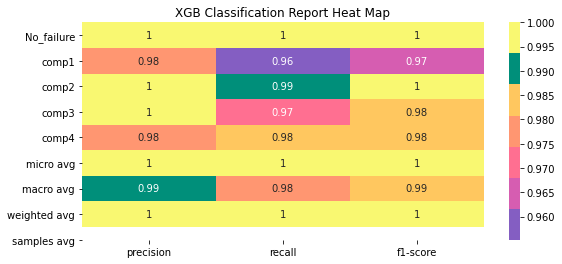

In [45]:
cr_XGB_case1=classification_report_heatmap(encoded_y_test,XGB_y_pred,'XGB')

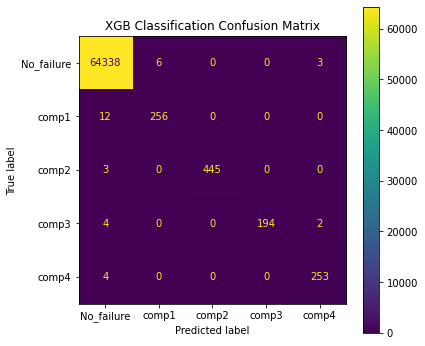

In [46]:
confusion_matrix_display(y_pred=XGB_y_pred, y_test=encoded_y_test,model_name='XGB')

## K-Nearest Neighbours

In [47]:
np.random.seed(seed)

start_time=time.process_time()
KNN=KNeighborsClassifier()
model2=KNN.fit(scaled_X_train,encoded_y_train)
end_time=time.process_time()
print('CPU Execution time for training is ', end_time-start_time, 'seconds')

CPU Execution time for training is  0.029393604000006235 seconds


In [48]:
start_time=time.process_time()
KNN_y_pred=model2.predict(scaled_X_test)
end_time=time.process_time()
print('CPU Execution time for prediction is ', end_time-start_time, 'seconds')

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f38cc7cdca0>
Traceback (most recent call last):
  File "/home/mizolotu/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mizolotu/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mizolotu/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mizolotu/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


CPU Execution time for prediction is  68.14901755100001 seconds


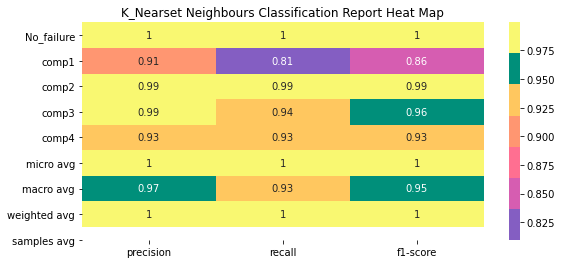

In [49]:
cr_KNN_case1=classification_report_heatmap(encoded_y_test,KNN_y_pred,'K_Nearset Neighbours')

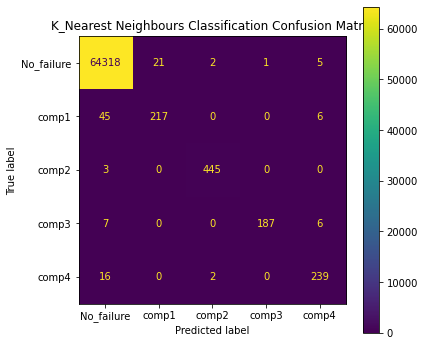

In [50]:
confusion_matrix_display(y_pred=KNN_y_pred, y_test=encoded_y_test,model_name='K_Nearest Neighbours')

## Random forest classifier

In [51]:
np.random.seed(seed)

start_time=time.process_time()
RF = RandomForestClassifier(random_state=seed)
model3=RF.fit(scaled_X_train,encoded_y_train)
end_time=time.process_time()
print('CPU Execution time for training is ', end_time-start_time, 'seconds')

CPU Execution time for training is  47.73111156799996 seconds


In [52]:
start_time=time.process_time()
RF_y_pred = model3.predict(scaled_X_test)
end_time=time.process_time()
print('CPU Execution time for prediction is ', end_time-start_time, 'seconds')

CPU Execution time for prediction is  0.32205005000002984 seconds


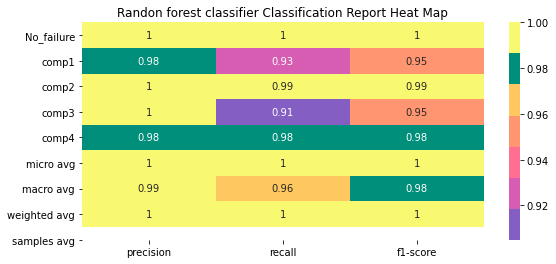

In [53]:
cr_RF_case1=classification_report_heatmap(encoded_y_test,RF_y_pred,'Randon forest classifier')

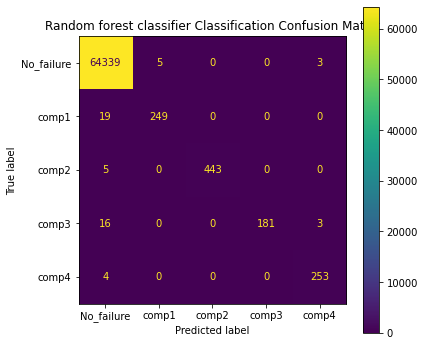

In [54]:
confusion_matrix_display(y_pred=RF_y_pred, y_test=encoded_y_test,model_name='Random forest classifier')

## Logistic  regression

In [55]:
np.random.seed(seed)

start_time=time.process_time()
LR=LogisticRegression()
model4=LR.fit(scaled_X_train,encoded_y_train)
end_time=time.process_time()
print('CPU Execution time for training is ', end_time-start_time, 'seconds')

CPU Execution time for training is  80.30024053 seconds


In [56]:
start_time=time.process_time()
LR_y_pred=model4.predict(scaled_X_test)
end_time=time.process_time()
print('CPU Execution time for training is ', end_time-start_time, 'seconds')

CPU Execution time for training is  0.11067500900003324 seconds


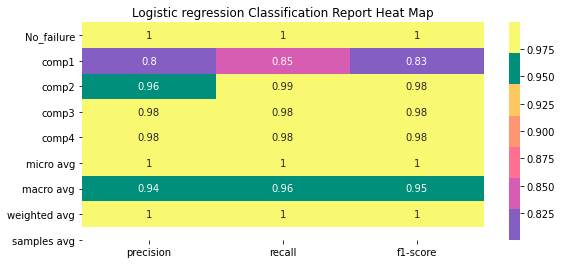

In [57]:
cr_LR_case1=classification_report_heatmap(encoded_y_test,LR_y_pred,'Logistic regression')

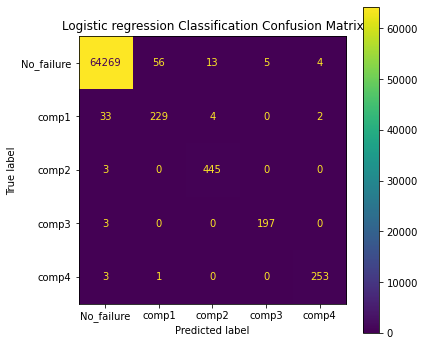

In [58]:
confusion_matrix_display(y_pred=LR_y_pred, y_test=encoded_y_test,model_name='Logistic regression')

## Neural network

In [59]:
import tensorflow as tf

In [60]:
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

layers = [2048, 2048]
loss = 'categorical_crossentropy'
epochs = 10000
patience = 30
lr = 1e-3
batch_size = 4096
val_split = 0.2
dropout = 0.5
metrics = [tf.keras.metrics.CategoricalAccuracy()]

input_shape = X.shape[1:]
output_dim = len(np.unique(encoded_y_train))

inputs = tf.keras.layers.Input(shape=input_shape)
hidden = inputs 

for units in layers:
    hidden = tf.keras.layers.Dense(units=units, activation='relu')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

outputs = tf.keras.layers.Dense(units=output_dim, activation='softmax')(hidden)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=metrics,
)

model_summary = []
model.summary(print_fn=lambda x: model_summary.append(x))
summary = "\n".join(model_summary)
print(summary)

Y_train = np.zeros((len(encoded_y_train), output_dim))
Y_train[np.arange(encoded_y_train.size), encoded_y_train] = 1

bin_counts = np.sum(Y_train, 0)
idx = np.arange(X_train.shape[0])
idx_oversampled = []

for i in range(output_dim):
    idx_i = np.where(encoded_y_train == i)[0]
    idx_oversampled.append(np.random.choice(idx_i, int(np.max(bin_counts))))

idx_oversampled = np.hstack(idx_oversampled)

np.random.shuffle(idx_oversampled)

X_train_oversampled = scaled_X_train[idx_oversampled, :]
print(f'Before: {scaled_X_train.shape}, after: {X_train_oversampled.shape}')

Y_train_oversampled = Y_train[idx_oversampled, :]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46)]              0         
                                                                 
 dense (Dense)               (None, 2048)              96256     
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 4,302,853
Trainable params: 4,302,853
Non-train

In [61]:
model.fit(
    X_train_oversampled, Y_train_oversampled,
    validation_split=val_split,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)
    ],
    verbose=True
)

Epoch 1/10000
147/147 [==============================] - 4s 20ms/step - loss: 0.0581 - categorical_accuracy: 0.9843 - val_loss: 0.0050 - val_categorical_accuracy: 0.9989
Epoch 2/10000
147/147 [==============================] - 3s 19ms/step - loss: 0.0043 - categorical_accuracy: 0.9991 - val_loss: 0.0030 - val_categorical_accuracy: 0.9994
Epoch 3/10000
147/147 [==============================] - 3s 19ms/step - loss: 0.0028 - categorical_accuracy: 0.9995 - val_loss: 0.0025 - val_categorical_accuracy: 0.9996
Epoch 4/10000
147/147 [==============================] - 3s 19ms/step - loss: 0.0022 - categorical_accuracy: 0.9996 - val_loss: 0.0021 - val_categorical_accuracy: 0.9996
Epoch 5/10000
147/147 [==============================] - 3s 19ms/step - loss: 0.0020 - categorical_accuracy: 0.9997 - val_loss: 0.0026 - val_categorical_accuracy: 0.9996
Epoch 6/10000
147/147 [==============================] - 3s 19ms/step - loss: 0.0019 - categorical_accuracy: 0.9997 - val_loss: 0.0020 - val_categoric

147/147 [==============================] - 3s 19ms/step - loss: 6.4296e-04 - categorical_accuracy: 0.9999 - val_loss: 5.6177e-04 - val_categorical_accuracy: 0.9998
Epoch 49/10000
147/147 [==============================] - 3s 20ms/step - loss: 6.8188e-04 - categorical_accuracy: 0.9999 - val_loss: 6.4411e-04 - val_categorical_accuracy: 0.9998
Epoch 50/10000
147/147 [==============================] - 3s 19ms/step - loss: 6.3916e-04 - categorical_accuracy: 0.9999 - val_loss: 4.0114e-04 - val_categorical_accuracy: 0.9999
Epoch 51/10000
147/147 [==============================] - 3s 20ms/step - loss: 6.7008e-04 - categorical_accuracy: 0.9999 - val_loss: 3.9948e-04 - val_categorical_accuracy: 0.9999
Epoch 52/10000
147/147 [==============================] - 3s 19ms/step - loss: 6.2807e-04 - categorical_accuracy: 0.9999 - val_loss: 4.8734e-04 - val_categorical_accuracy: 0.9999
Epoch 53/10000
147/147 [==============================] - 3s 20ms/step - loss: 6.3312e-04 - categorical_accuracy: 0.9999

Epoch 94/10000
147/147 [==============================] - 3s 20ms/step - loss: 4.8385e-04 - categorical_accuracy: 0.9999 - val_loss: 2.0345e-04 - val_categorical_accuracy: 0.9999
Epoch 95/10000
147/147 [==============================] - 3s 20ms/step - loss: 3.6182e-04 - categorical_accuracy: 0.9999 - val_loss: 1.0265e-04 - val_categorical_accuracy: 1.0000
Epoch 96/10000
147/147 [==============================] - 3s 20ms/step - loss: 4.6757e-04 - categorical_accuracy: 0.9999 - val_loss: 1.6624e-04 - val_categorical_accuracy: 1.0000
Epoch 97/10000
147/147 [==============================] - 3s 20ms/step - loss: 4.4803e-04 - categorical_accuracy: 0.9999 - val_loss: 2.4770e-04 - val_categorical_accuracy: 1.0000
Epoch 98/10000
147/147 [==============================] - 3s 20ms/step - loss: 5.5070e-04 - categorical_accuracy: 0.9999 - val_loss: 1.5154e-04 - val_categorical_accuracy: 1.0000
Epoch 99/10000
147/147 [==============================] - 3s 20ms/step - loss: 2.7641e-04 - categorical_a

147/147 [==============================] - 3s 21ms/step - loss: 3.2281e-04 - categorical_accuracy: 0.9999 - val_loss: 9.6747e-05 - val_categorical_accuracy: 1.0000
Epoch 140/10000
147/147 [==============================] - 3s 21ms/step - loss: 2.7409e-04 - categorical_accuracy: 0.9999 - val_loss: 2.4139e-05 - val_categorical_accuracy: 1.0000
Epoch 141/10000
147/147 [==============================] - 3s 20ms/step - loss: 3.3574e-04 - categorical_accuracy: 0.9999 - val_loss: 5.7645e-05 - val_categorical_accuracy: 1.0000
Epoch 142/10000
147/147 [==============================] - 3s 21ms/step - loss: 2.1135e-04 - categorical_accuracy: 1.0000 - val_loss: 1.6043e-05 - val_categorical_accuracy: 1.0000
Epoch 143/10000
147/147 [==============================] - 3s 20ms/step - loss: 1.9638e-04 - categorical_accuracy: 1.0000 - val_loss: 7.3910e-05 - val_categorical_accuracy: 1.0000
Epoch 144/10000
147/147 [==============================] - 3s 21ms/step - loss: 4.0811e-04 - categorical_accuracy: 0

In [62]:
P_test = model.predict(scaled_X_test, batch_size=batch_size)
NN_y_pred = np.argmax(P_test, 1)

16/16 [==============================] - 0s 5ms/step


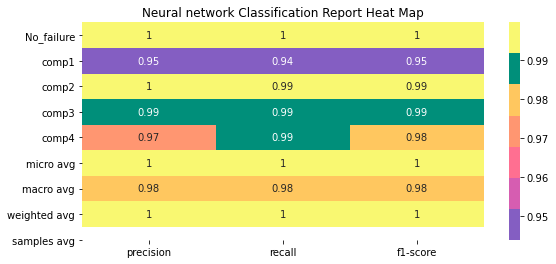

In [63]:
cr_NN_case1 = classification_report_heatmap(encoded_y_test, NN_y_pred, 'Neural network')

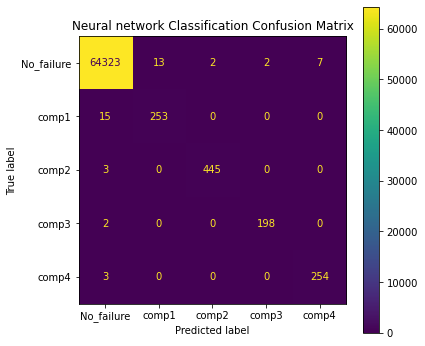

In [64]:
confusion_matrix_display(y_pred=NN_y_pred, y_test=encoded_y_test, model_name='Neural network')

##  ML models comparison

#### Precision scores

In [65]:
models = ["XGB classifier", "K-Nearest Neighbours","Random Forest classifier","Logistic regression", 'Neural network']
crs = [cr_XGB_case1, cr_KNN_case1, cr_RF_case1, cr_LR_case1, cr_NN_case1]
colors = ["#845EC2", "#D65DB1", "#FF6F91", "#FF9671", "#FFC75F", "#008F7A", "#F9F871"]

failure_precision_score = comp_failure_scores(models, crs, metric="precision")
failure_precision_score.style.background_gradient(cmap='YlOrRd').hide_index()

ImportError: Pandas requires version '3.0.0' or newer of 'jinja2' (version '2.11.2' currently installed).

In [ ]:
failure_precision_score.plot.bar(figsize=(10,6), color=colors)
#plt.title("Precision Scores of Detecting Different componant Failure Based on Model", fontweight="bold")
plt.xlabel("Model")
plt.ylabel("Precision")
plt.xticks([i for i in range(len(models))], models, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Recall scores

In [ ]:
failure_recall_score = comp_failure_scores(models, crs, metric="recall")
failure_recall_score.style.background_gradient(cmap='YlOrRd').hide_index()

In [ ]:
failure_recall_score.plot.bar(figsize=(10,6), color=colors)
#plt.title("Recall Scores of Detecting Different componant Failure Based on Model", fontweight="bold")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.xticks([i for i in range(len(models))], models, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### F1-scores

In [ ]:
failure_f1_score = comp_failure_scores(models, crs, metric="f1-score")
failure_f1_score.style.background_gradient(cmap='YlOrRd').hide_index()

In [ ]:
failure_f1_score.plot.bar(figsize=(10,6), color=colors)
#plt.title("F1 Scores of Detecting Different componant Failure Based on Model", fontweight="bold")
plt.xlabel("Model")
plt.ylabel("F1-score")
plt.xticks([i for i in range(len(models))], models, rotation='vertical')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Conclusion

- The models have done pretty good job in prediction even without any hyperparameter tuning.
- The models give better predictions for case 1 data labeling comparing to case 2.
- Considering case 1 we can notice that the K_Nearset Neighbour has the lost scores. And the scores for comp 1 failure prediction are the lowest for all models.
- For case 2, the k_Nearest neighbors give the best precision and the XGB give the worst.
- For case 2,  the XGB give better recall score than the others model. Both k_Nearest Neighbour and the logistic regrssion give almost same recall scores.
- Here the lable encoder is used for encoding y_train and y_test. The one-hot encoder is also used (results are in the file 'ML_hotEnco'). The one_hot enconder is not applied for logitic regression model as it requires 1D array for y-train. The method of encoding, for case1, does not affect the metrics for KNN and for RF, whereas the recall for XGB is slightly lower for comp 1 prediction when using the one_hot encoder. Howevere, a silight difference can be seen in case 2. For case 2, the precision vlaues are a bit higher and the recall values are a bit lower when the one_hot encoder is used for XGB and RF models, while similar results are shown for the KNN model.  